# Toy Example 

This notebook is a walkthrough off training and inferencing on a small toy graph using GiGL


## Overview Of Components
This notebook shows the process of a simple, human-digestable graph being passed through all the pipeline components in GiGL in preperation for training to help understand how each of the components work.

The pipeline consists of the following components:

- **Config Populator**: Takes a template config and creates a frozen workflow config that dictates all inputs/outputs and business parameters that is read and used by each subsequent component.
    - input: template_config.yaml
    - output: frozen_gbml_config.yaml
&nbsp;

&nbsp;


- **Data Preprocesser**: Transforms necessary node and edge feature assets as needed as a precursor step in most ML tasks according to user provided data preprocessor config class
    - input: frozen_gbml_config.yaml which includes user-defined preprocessor class for custom logic and custom arguments can be passed under dataPreprocessorArgs
    - output: PreprocessedMetadata Proto which includes inferred GraphMetadata and preproccessed graph data Tfrecords after applying user defined preprocessing function
&nbsp;

&nbsp;


- **Subgraph Sampler**: Samples k-hop subgraphs for each node according to user provided arguments
    - input: frozen_gbml_config.yaml, resource_config.yaml
    - output: Subgraph Samples (tfrecord format based on predefined schema in protos) are stored in the uri defined in flattenedGraphMetadata field. 
&nbsp;

&nbsp;


- **Split Generator**: Splits subgraph sampler outputs into train/test/val sets according to user provided split strategy class.
    - input: frozen_gbml_config.yaml which includes instance of SplitStrategy and an instance of Assigner
    - output: TFRecord samples
&nbsp;

&nbsp;


- **Trainer**: The trainer component reads the output of split generator and trains a model on the training set, stops based on validation set, and evaluates on the test set
    - input: frozen_gbml_config.yaml
    - output: state_dict stored in trainedModelUri
&nbsp;

&nbsp;


- **Inferencer**: Runs inference of a trained model on samples generated by Subgraph Sampler. 
    - input: frozen_gbml_config.yaml
    - output: Embeddings and/or prediction assets
&nbsp;

&nbsp;

## Input Graph

We use the input graph defined in [examples/toy_visual_example/graph_config.yaml](./graph_config.yaml). 
You are welcome to change this file to a custom graph off your own choosing.


We render the graph below.

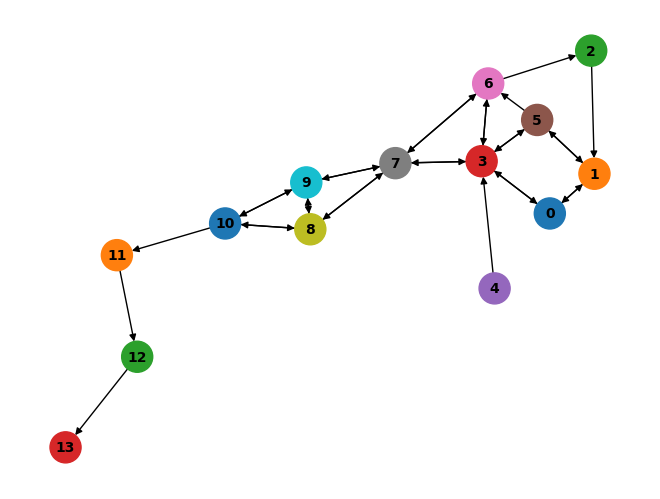

In [1]:
from torch_geometric.data import HeteroData
from visualize import GraphVisualizer

from gigl.src.mocking.toy_asset_mocker import load_toy_graph

data: HeteroData = load_toy_graph(graph_config="./graph_config.yaml")
# Visualize the graph
GraphVisualizer.visualize_graph(data)

In [12]:
toy_data = data
# Extract edge types and node types from the HeteroData object
edge_types = list(toy_data.edge_types)
node_types = list(toy_data.node_types)

# Build edge_index, node_feats, and edge_feats dictionaries
edge_index = {et: toy_data[et].edge_index for et in edge_types}
node_feats = {nt: toy_data[nt].x for nt in node_types}
edge_feats = {et: toy_data[et].edge_attr for et in edge_types if hasattr(toy_data[et], "edge_attr")}
edge_index

{('user',
  'friend',
  'user'): tensor([[ 0,  0,  1,  1,  2,  3,  3,  3,  3,  4,  5,  5,  5,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 12],
         [ 1,  3,  0,  5,  1,  0,  5,  6,  7,  3,  1,  3,  6,  2,  3,  7,  3,  6,
           8,  9,  7,  9, 10,  7,  8, 10, 11,  9,  8, 12, 13]])}

### Setting up Configs

The first thing we will need to do is create the resource and task configs. 

- **Resource Config**: Details the resource allocation and environmental settings across all GiGL components. This
  encompasses shared resources for all components, as well as component-specific settings. See [Resource Config Guide](../../docs/user_guide/config_guides/resource_config_guide.md)

- **Task Config**: Specifies task-related configurations, guiding the behavior of components according to the needs of
  your machine learning task. See [Task Config Guide](../../docs/user_guide/config_guides/task_config_guide.md)


If you have not already, please follow the [Quick Start Guide](../../docs/user_guide/getting_started/quick_start.md) to setup your cloud environment and setup a default test resource config. Without setting up these prerequisited you won't be able to execute the rest of the notebook in your own project.

In [2]:
import os
from gigl.common import Uri, UriFactory

# You are welcome to customize these  to point to your own configuration files.
JOB_NAME = "gigl_test_job"
TASK_CONFIG_PATH: Uri = UriFactory.create_uri("./task_config.yaml")
RESOURCE_CONFIG_PATH: Uri = UriFactory.create_uri(os.getenv("GIGL_TEST_DEFAULT_RESOURCE_CONFIG", "./resource_config.yaml"))

In [3]:
from gigl.src.validation_check.config_validator import kfp_validation_checks
validator = kfp_validation_checks(
    job_name=JOB_NAME,
    task_config_path=TASK_CONFIG_PATH,
    resource_config_path=RESOURCE_CONFIG_PATH,
)

ModuleNotFoundError: No module named 'tensorflow_data_validation'

In [3]:

import yaml
import os

yaml_file = "TODO/gbml_toy_config.yaml"

def visualize_yaml(file_path):
    with open(file_path, 'r') as yaml_file:
        yaml_data = yaml.safe_load(yaml_file)

    print(yaml.dump(yaml_data))

print("GBML Config for Toy Graph:")
visualize_yaml(yaml_file)

GBML Config for Toy Graph:


FileNotFoundError: [Errno 2] No such file or directory: 'TODO/gbml_toy_config.yaml'



The graph/data type you are using must have an instance of the `DataPreprocessorConfig` class (see `dataPreprocessorConfigClsPath` field of `datasetConfig.dataPreprocessorConfig`). For more information on this class, see the DataPreprocessor Section

A toy graph preprocessor class can be found [Here](../../../../../internal/applied_tasks/mocking/toy_graph/toy_data_preprocessor_config.py) which will be used in the config for this notebook's demonstration

Alternatively, you can pass in  `bq_edges_table_name` and `bq_nodes_table_name` in the config file as runtime arguments under dataPreprocessorArgs. These two indicate where the graphs can be found in BigQuery and additional prepare_for_pipeline logic is not needed for pulling data since it is already implemented in the [ToyDataPreprocessorConfig Class](https://github.com/Snapchat/GiGL/blob/622d5b5c5f5dcb07a07b52e7e85848bc318537e8/internal/applied_tasks/mocking/toy_graph/toy_data_preprocessor_config.py#L38). You can use the [Mocking Suite](../dataset_asset_mocking_suite.py) to populate BigQuery with the custom graph that was configured in the [graph_config.yaml](./graph_config.yaml). There is a method in the mocking suite called `_create_custom_toy_graph` which will be used in the `mock_toy_graph_homogeneous_unsupervised_node_anchor_based_link_prediction_dataset` function to populate the custom graph in BigQuery. The steps to do this are the following:

1. Locate the `mock_toy_graph_homogeneous_unsupervised_node_anchor_based_link_prediction_dataset` in the mocking suite. 
2. Set toy_graph = self._create_custom_toy_graph("PATH/TO/GRAPH_CONFIG.yaml")
3. Change the name parameter (Note: this is the prefix of the name that will appear in BigQuery)
4. Run the command seen below:



In [ ]:
%%bash

cd ~/GiGL

cd python && python -m tests.test_assets.dataset_mocking.dataset_asset_mocking_suite  --select mock_toy_graph_homogeneous_unsupervised_node_anchor_based_link_prediction_dataset  --env test

### Config Populator

Now that the graph data has been populated and reflected in the config, we can proceed to the first step of the pipeline. The Config Populator takes a "template" config and generates a "frozen" config to be used by all subsequent components. The frozen config contains some information that is not in the original config but is needed for other parts of the pipeline. To run config poplulator we can just do the following:

In [ ]:
%%bash
python -m \
    gigl.src.config_populator.config_populator \
    --job_name toy_graph \
    --template_uri toy_graph/configs/gbml_toy_config.yaml \
    --output_file_path_frozen_gbml_config_uri toy_graph/configs/toy_graph-frozen-config_path.yaml

So, now we have:

In [ ]:
from gigl.common.utils.proto_utils import ProtoUtils
from gigl.common import UriFactory
from snapchat.research.gbml import gbml_config_pb2

frozen_config_uri = "gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml"

# Frozen config proto
proto_utils = ProtoUtils()
frozen_config = proto_utils.read_proto_from_yaml(
        uri=UriFactory.create_uri(
            uri=frozen_config_uri
        ),
        proto_cls=gbml_config_pb2.GbmlConfig,
    )

In [ ]:
# Copy frozen config to local
!gsutil cp gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml .

import yaml

yaml_file = "./frozen_gbml_config.yaml"

def visualize_yaml(file_path):
    with open(file_path, 'r') as yaml_file:
        yaml_data = yaml.safe_load(yaml_file)

    print(yaml.dump(yaml_data))

print("Frozen GBML Config Yaml:")
visualize_yaml(yaml_file)

Below is a code snippet to output the difference between the original config file and the frozen config to illustrate what ConfigPopulator adds

In [ ]:
import yaml

def compare_yaml(file_path1, file_path2):
    with open(file_path1, 'r') as yaml_file1:
        yaml_data1 = yaml.safe_load(yaml_file1)

    with open(file_path2, 'r') as yaml_file2:
        yaml_data2 = yaml.safe_load(yaml_file2)

    diff = compare_dicts(yaml_data1, yaml_data2)
    print(yaml.dump(diff, default_flow_style=False))

def compare_dicts(dict1, dict2):
    diff = {}
    for key in set(dict2.keys()):
        if key not in dict1:
            diff[key] = dict2[key]
    return diff

gbml_config = "toy_graph/configs/gbml_toy_config.yaml"
frozen_config_local = "./frozen_gbml_config.yaml"
compare_yaml(gbml_config, frozen_config_local)

### Visualizing Input Graph

We have now configured everything required to run the subsequent steps. Before proceeding we can visualize what the input graph looks like to get a better understanding of what happens in each of the steps.

In [1]:
from visualize import GraphVisualizer

%config InlineBackend.figure_format = 'svg'

graph_visualizer = GraphVisualizer("./graph_config.yaml")
graph_visualizer.visualize_graph()

KeyError: 'node_type'

### Data Preprocessor

The Data Preprocessor uses Tensorflow Transform to achieve data transformation in a distributed fashion. Any custom preprocessing is to be defined in the preprocessor class that is inherited from the DataPreprocessorConfig class.

Overall, this class houses all logic for

- Preparing datasets for ingestion and transformation (see [`prepare_for_pipeline`](https://github.com/Snapchat/GiGL/blob/10f1a35196f3946ae14c3e8e57d1cb685f01ffb5/python/gigl/src/data_preprocessor/lib/data_preprocessor_config.py#L40) function) So this is where you would house logic to pull data from a custom data source or perform any specific transformations.
- Defining transformation imperatives for different node types (see [`get_nodes_preprocessing_spec`](https://github.com/Snapchat/GiGL/blob/10f1a35196f3946ae14c3e8e57d1cb685f01ffb5/python/gigl/src/data_preprocessor/lib/data_preprocessor_config.py#L54) function)
- Defining transformation imperatives for different edge types (see [`get_edges_preprocessing_spec`](https://github.com/Snapchat/GiGL/blob/10f1a35196f3946ae14c3e8e57d1cb685f01ffb5/python/gigl/src/data_preprocessor/lib/data_preprocessor_config.py#L60))

Upon completion, the data preprocesser writes out a PreprocessedMetadata proto as TFRecords to URI specified by the preprocessedMetadataUri field in the sharedConfig section of the frozen config as seen below: 

In [ ]:
print("Frozen Config Datapreprocessor Information:")

print("Preprocessed Metadata Uri: ", frozen_config.shared_config.preprocessed_metadata_uri)
print("Data Preprocessor Config: ", frozen_config.dataset_config.data_preprocessor_config)
print("Flattened Graph Metadata: ", frozen_config.shared_config.flattened_graph_metadata)



This proto contains a map to all information about the graph. Nothing has changed in terms of the structure of the graph from the input graph. Only features or transformations (i.e normalization) are applied to the graph.

To run the preprocessor we can do the following:

In [ ]:
%%bash -s "$frozen_config_uri"

python -m \
    gigl.src.data_preprocessor.data_preprocessor \
    --job_name toy_graph \
    --task_config_uri "$1"

Upon completion we would see three generated artifacts in the specified gs uri: `edge`, `node`, and `preprocessed_metadata.yaml`. The metadata contains all the inferred GraphMetadata of the graph. One unformatted sample from a tfrecord and the data that is actually stored is visualized below.

In [ ]:
from visualize_preprocessor_output import visualize_preprocessed_graph

preprocessed_metadata_uri = frozen_config.shared_config.preprocessed_metadata_uri
node_df, edge_df = visualize_preprocessed_graph(preprocessed_metadata_uri)

The output above visualized one sample of each of the TFRecord's that Data preprocessor creates. To visualize this output better, we can iterate through these TFRecord's and store them in two dataframes (node_df and edge_df)

In [ ]:
node_df

In [ ]:
edge_df

### Subgraph Sampler

The Subgraph Sampler receives node and edge data from Data Preprocessor and generates k-hop localized subgraphs for each node in the graph. The purpose is to store the neighborhood of each node independently, and as a result reducing the memory footprint for down-stream components, as they need not load the entire graph into memory but only batches of these node neighborhoods. 
To run subgraph sampler we use the following command:

In [ ]:
%%bash

cd ~/GiGL

make compile_jars

python -m gigl.src.subgraph_sampler.subgraph_sampler \
  --job_name="toy_graph" \
  --task_config_uri="gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml" \
  --resource_config_uri="deployment/configs/e2e_cicd_resource_config.yaml" \
  --main_jar_file_uri="$PACKAGE_GCS_PATH"

Upon completion, there will be two different directories of subgraph samples. One is the main node anchor based link prediction samples and the other is random negative rooted neigborhood samples which are stored in the locations specified in the frozen_config:

In [ ]:
print(frozen_config.shared_config.flattened_graph_metadata)


The main, unsupervised_node_anchor_based_link_prediction_samples include root nodes khop neighborhood, positive nodes khop neighborhood and positive edges. These samples will be used for training.
The random_negative_rooted_neighborhood_samples (which include root nodes khop neighborhood)samples are double purpose: they will be used for inferencer and random negative samples for training.

The random negative are used for the model to be able to learn non-existent (negative) edges since it could overfit on just positive samples. This means it would fail to generalize well to unseen data. The negative edges are just an edge chosen at random. At a large scale, this would most probably be a negative edge. 

Below we visualize the Root Node Neighbourhood of 5, the Root Node Neighbourhood of its pos_edge's destination node (1) and the resulting sample for root node 5. 

In [ ]:
from visualize_sgs_output import SGSVisualizer

sgs_visualizer = SGSVisualizer(frozen_config_uri)
sgs_visualizer.visualize_random_negative_sample(5)
sgs_visualizer.visualize_random_negative_sample(1)
sgs_visualizer.visualize_node_anchor_prediction_sample(5)

### Split Generator

The Split Generator reads localized subgraph samples produced by Subgraph Sampler, and executes the user specified split strategy logic to split the data into training, validation and test sets. Several standard configurations of SplitStrategy and corresponding Assigner classes are implemented already at a GiGL platform-level: transductive node classification, inductive node classification, and transductive link prediction split routines. For more information on split strategies in Graph Machine Learning checkout these resources:

1. http://web.stanford.edu/class/cs224w/slides/07-theory.pdf
2. https://zqfang.github.io/2021-08-12-graph-linkpredict/ (relevant for explaining transductive vs inductive) 

In this example, we are using the transductive strategy as specified in our frozen_config:

In [ ]:
print(frozen_config.dataset_config.split_generator_config)

For transductive, at training time, it uses training message edges to predict training supervision edges. At validation time, the training message edges and training supervision edges are used to predict the validation edges and then all 3 are used to predict test edges. Below is the command to run split generator:


In [ ]:
%%bash

python -m \
    gigl.src.split_generator.split_generator \
    --job_name toy_graph \
    --task_config_uri gs://TEMP DEV GBML PLACEHOLDER/toy_graph/config_populator/frozen_gbml_config.yaml

Upon completion, there will be 3 folders for train,test, and val. Each of them contains the protos for the positive and negaitve samples. The path for these folders is specified in the following location in the frozen_config:

In [ ]:
print(frozen_config.shared_config.dataset_metadata)


We can visualize the train,test, and val sample for the same root node as above (5) to see the pipeline process.

In [ ]:
from visualize_sgn_output import SGNVisualizer

sgn_vis = SGNVisualizer(frozen_config_uri)

In [ ]:
sgn_vis.visualize_main_data_output(5)

At this point, we have our graph data samples ready to be processed by the trainer and inferencer components. These components will extract representations/embeddings by learning contextual information for the specified task.